In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from scipy.stats import norm
from sklearn.metrics import r2_score

In [2]:
# Laste poll-of-polls data
df = pd.read_csv("../data/v2_data_juli.csv", sep=",")

In [3]:
df

,Mnd,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,...,Rodt_reg_lag3,Rodt_reg_lag6,Andre_reg_lag3,Andre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
0,1/31/2008,29.3,17.2,23.9,7.4,6.1,6.4,6.5,0.0,1.3,...,NaN,NaN,NaN,NaN,2.6,NaN,NaN,5.25,NaN,NaN
1,2/29/2008,29.0,17.3,25.2,6.7,5.9,6.3,6.6,0.0,1.3,...,NaN,NaN,NaN,NaN,2.6,NaN,NaN,5.25,NaN,NaN
2,3/31/2008,28.7,18.1,25.2,7.0,5.6,6.1,6.3,0.0,1.1,...,0.0,NaN,0.0,NaN,2.6,0.000,NaN,5.25,0.000000,NaN
3,4/30/2008,29.0,16.9,25.4,6.5,5.5,7.0,6.8,0.0,1.2,...,0.0,NaN,0.0,NaN,2.7,0.033,NaN,5.31,0.020000,NaN
4,5/31/2008,28.9,17.8,25.9,6.7,5.7,6.2,6.2,0.0,1.4,...,0.0,NaN,0.0,NaN,2.8,0.067,NaN,5.50,0.083333,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,5/31/2025,28.5,18.7,20.6,7.0,5.7,3.6,4.1,2.7,5.3,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.20,-0.100000,-0.050000
209,6/30/2025,28.3,16.2,21.0,6.9,5.6,3.7,4.5,3.0,6.2,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.20,0.000000,-0.050000
210,7/31/2025,27.7,14.8,21.5,8.2,6.3,3.2,4.7,3.5,5.9,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.00,-0.066667,-0.083333
211,8/31/2025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,4.0,0.000,0.000000,4.00,-0.066667,-0.083333


In [4]:
ex_future=df[df['Ap'].isna()][['Mnd',
       'Ap_skandale_lag6', 'Hoyre_skandale_lag6', 'Frp_skandale_lag6',
       'SV_skandale_lag6', 'SP_skandale_lag6', 'KrF_skandale_lag6',
        'Rodt_skandale_lag6',
        'Ap_reg_lag6',
        'Hoyre_reg_lag6', 
        #'Frp_reg_lag6','SV_reg_lag6', 
        #'SP_reg_lag6','KrF_reg_lag6',
        #'Venstre_reg_lag6', 
       'ledighet', 'ledig_trend3', 'ledig_trend6', 'styringsrente',
       'styringsrente_trend3', 'styringsrente_trend6']]

In [5]:
ex_future
ex_future["Mnd"] = pd.to_datetime(df["Mnd"])
ex_future.set_index("Mnd", inplace=True)

In [6]:
df.dropna(inplace=True)

In [7]:
df

,Mnd,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,...,Rodt_reg_lag3,Rodt_reg_lag6,Andre_reg_lag3,Andre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
5,6/30/2008,26.0,17.6,28.9,6.9,5.3,6.1,5.9,0.0,1.8,...,0.0,0.0,0.0,0.0,2.9,0.067,0.050000,5.54,0.076667,0.048333
6,7/31/2008,26.9,17.2,30.2,6.6,4.7,6.1,5.4,0.0,1.9,...,0.0,0.0,0.0,0.0,2.9,0.033,0.050000,5.75,0.083333,0.083333
7,8/31/2008,26.6,16.2,30.9,6.7,5.2,5.5,6.0,0.0,1.7,...,0.0,0.0,0.0,0.0,3.0,0.033,0.066667,5.75,0.070000,0.083333
8,9/30/2008,28.9,15.2,29.9,6.3,5.0,5.7,5.9,0.0,1.5,...,0.0,0.0,0.0,0.0,3.1,0.067,0.066667,5.75,0.000000,0.073333
9,10/31/2008,30.6,16.1,26.7,7.3,5.3,5.6,5.5,0.0,1.2,...,0.0,0.0,0.0,0.0,3.1,0.033,0.050000,5.45,-0.100000,-0.008333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,3/31/2025,28.1,18.8,22.7,7.2,4.9,3.1,4.3,2.7,4.6,...,0.0,0.0,0.0,0.0,4.0,-0.033,0.000000,4.50,0.000000,0.000000
207,4/30/2025,28.1,19.8,20.0,6.3,6.7,3.3,3.9,3.1,4.8,...,0.0,0.0,0.0,0.0,4.0,-0.033,-0.016667,4.20,-0.100000,-0.050000
208,5/31/2025,28.5,18.7,20.6,7.0,5.7,3.6,4.1,2.7,5.3,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.20,-0.100000,-0.050000
209,6/30/2025,28.3,16.2,21.0,6.9,5.6,3.7,4.5,3.0,6.2,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.20,0.000000,-0.050000


In [8]:
# Convert to datetime and set the date to the end of the month
df["Mnd"] = pd.to_datetime(df["Mnd"])

In [9]:
# Sort values and set index
df = df.sort_values("Mnd")
df.set_index("Mnd", inplace=True)

In [10]:
df

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre,...,Rodt_reg_lag3,Rodt_reg_lag6,Andre_reg_lag3,Andre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
Mnd,,,,,,,,,,,,,,,,,,,,,
2008-06-30,26.0,17.6,28.9,6.9,5.3,6.1,5.9,0.0,1.8,0.0,...,0.0,0.0,0.0,0.0,2.9,0.067,0.050000,5.54,0.076667,0.048333
2008-07-31,26.9,17.2,30.2,6.6,4.7,6.1,5.4,0.0,1.9,0.0,...,0.0,0.0,0.0,0.0,2.9,0.033,0.050000,5.75,0.083333,0.083333
2008-08-31,26.6,16.2,30.9,6.7,5.2,5.5,6.0,0.0,1.7,0.0,...,0.0,0.0,0.0,0.0,3.0,0.033,0.066667,5.75,0.070000,0.083333
2008-09-30,28.9,15.2,29.9,6.3,5.0,5.7,5.9,0.0,1.5,0.0,...,0.0,0.0,0.0,0.0,3.1,0.067,0.066667,5.75,0.000000,0.073333
2008-10-31,30.6,16.1,26.7,7.3,5.3,5.6,5.5,0.0,1.2,0.0,...,0.0,0.0,0.0,0.0,3.1,0.033,0.050000,5.45,-0.100000,-0.008333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-31,28.1,18.8,22.7,7.2,4.9,3.1,4.3,2.7,4.6,3.4,...,0.0,0.0,0.0,0.0,4.0,-0.033,0.000000,4.50,0.000000,0.000000
2025-04-30,28.1,19.8,20.0,6.3,6.7,3.3,3.9,3.1,4.8,3.9,...,0.0,0.0,0.0,0.0,4.0,-0.033,-0.016667,4.20,-0.100000,-0.050000
2025-05-31,28.5,18.7,20.6,7.0,5.7,3.6,4.1,2.7,5.3,3.8,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.20,-0.100000,-0.050000


In [11]:
df_en=df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]
#df_en = df_en / 100
df_en

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre
Mnd,,,,,,,,,,
2008-06-30,26.0,17.6,28.9,6.9,5.3,6.1,5.9,0.0,1.8,0.0
2008-07-31,26.9,17.2,30.2,6.6,4.7,6.1,5.4,0.0,1.9,0.0
2008-08-31,26.6,16.2,30.9,6.7,5.2,5.5,6.0,0.0,1.7,0.0
2008-09-30,28.9,15.2,29.9,6.3,5.0,5.7,5.9,0.0,1.5,0.0
2008-10-31,30.6,16.1,26.7,7.3,5.3,5.6,5.5,0.0,1.2,0.0
...,...,...,...,...,...,...,...,...,...,...
2025-03-31,28.1,18.8,22.7,7.2,4.9,3.1,4.3,2.7,4.6,3.4
2025-04-30,28.1,19.8,20.0,6.3,6.7,3.3,3.9,3.1,4.8,3.9
2025-05-31,28.5,18.7,20.6,7.0,5.7,3.6,4.1,2.7,5.3,3.8


In [12]:
df_ex=df[[
       'Ap_skandale_lag6', 'Hoyre_skandale_lag6', 'Frp_skandale_lag6',
       'SV_skandale_lag6', 'SP_skandale_lag6', 'KrF_skandale_lag6',
       #'Venstre_skandale_lag6', 
        #'MDG_skandale_lag6', 
       'Rodt_skandale_lag6',
       #'Andre_skandale_lag6', 
       # 'Ap_reg', 'Hoyre_reg', 'Frp_reg', 'SV_reg',
       #'SP_reg', 'KrF_reg', 'Venstre_reg', 'MDG_reg', 'Rodt_reg', 'Andre_reg',
       #'Ap_reg_lag3', 
       'Ap_reg_lag6',
        'Hoyre_reg_lag6', 
       # 'Frp_reg_lag6','SV_reg_lag6', 
       # 'SP_reg_lag6','KrF_reg_lag6',
       # 'Venstre_reg_lag6', 
        #'MDG_reg_lag6',
        #'Rodt_reg_lag6', 
        #'Andre_reg_lag6',
       'ledighet', 'ledig_trend3', 'ledig_trend6', 'styringsrente',
       'styringsrente_trend3', 'styringsrente_trend6']]#.iloc[1:]

In [13]:
df_ex

,Ap_skandale_lag6,Hoyre_skandale_lag6,Frp_skandale_lag6,SV_skandale_lag6,SP_skandale_lag6,KrF_skandale_lag6,Rodt_skandale_lag6,Ap_reg_lag6,Hoyre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
Mnd,,,,,,,,,,,,,,,
2008-06-30,1.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,2.9,0.067,0.050000,5.54,0.076667,0.048333
2008-07-31,1.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,2.9,0.033,0.050000,5.75,0.083333,0.083333
2008-08-31,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,3.0,0.033,0.066667,5.75,0.070000,0.083333
2008-09-30,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,3.1,0.067,0.066667,5.75,0.000000,0.073333
2008-10-31,1.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,3.1,0.033,0.050000,5.45,-0.100000,-0.008333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,4.0,-0.033,0.000000,4.50,0.000000,0.000000
2025-04-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,4.0,-0.033,-0.016667,4.20,-0.100000,-0.050000
2025-05-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,4.0,0.000,-0.016667,4.20,-0.100000,-0.050000


In [14]:
model = VARMAX(endog=df_en, exog=df_ex, order=(1,0), trend='n')
model_fitted = model.fit(disp=True, method='powell', cov_type='robust_approx', maxiter=100)

#print(model_fitted.summary())

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 6.744825
         Iterations: 34
         Function evaluations: 96005


In [15]:
print(model_fitted.mle_retvals)

{'fopt': 6.744825248713448, 'direc': array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 5.83308058e-03, -8.56142883e-04, -4.22375478e-03, ...,
         2.66358354e-04, -3.46346968e-05, -3.21532044e-05]]), 'iterations': 34, 'fcalls': 96005, 'warnflag': 0, 'converged': True}


In [16]:
#model = VAR(endog=df_en, exog=df_ex)

In [17]:
#model_fitted = model.fit(maxlags=6,method = 'ols', trend='c', verbose=True, ic='fpe')
#print(model_fitted.summary())

In [18]:
df_en.loc[model_fitted.fittedvalues.index]

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre
Mnd,,,,,,,,,,
2008-06-30,26.0,17.6,28.9,6.9,5.3,6.1,5.9,0.0,1.8,0.0
2008-07-31,26.9,17.2,30.2,6.6,4.7,6.1,5.4,0.0,1.9,0.0
2008-08-31,26.6,16.2,30.9,6.7,5.2,5.5,6.0,0.0,1.7,0.0
2008-09-30,28.9,15.2,29.9,6.3,5.0,5.7,5.9,0.0,1.5,0.0
2008-10-31,30.6,16.1,26.7,7.3,5.3,5.6,5.5,0.0,1.2,0.0
...,...,...,...,...,...,...,...,...,...,...
2025-03-31,28.1,18.8,22.7,7.2,4.9,3.1,4.3,2.7,4.6,3.4
2025-04-30,28.1,19.8,20.0,6.3,6.7,3.3,3.9,3.1,4.8,3.9
2025-05-31,28.5,18.7,20.6,7.0,5.7,3.6,4.1,2.7,5.3,3.8


In [19]:
r2_scores = {}
for party in df_en.columns:
    # Align true vs fitted
    y_true = df_en[party].loc[model_fitted.fittedvalues.index]
    y_pred = model_fitted.fittedvalues[party]

    r2_scores[party] = r2_score(y_true, y_pred)

# Print R² values
for party, r2 in r2_scores.items():
    print(f"R² for {party}: {r2:.4f}")

R² for Ap: 0.9436
R² for Hoyre: 0.9341
R² for Frp: 0.9536
R² for SV: 0.9479
R² for SP: 0.9558
R² for KrF: 0.8694
R² for Venstre: 0.8138
R² for MDG: 0.9676
R² for Rodt: 0.9581
R² for Andre: 0.9438


In [20]:
all_fitted= model_fitted.fittedvalues

In [21]:
all_fitted

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre
Mnd,,,,,,,,,,
2008-06-30,27.089260,15.869926,28.474764,7.593203,5.263679,5.440611,5.585711,0.484405,2.056119,0.911338
2008-07-31,26.581783,17.342621,28.914095,7.078878,5.120934,5.712477,5.733545,0.155659,1.686601,0.290288
2008-08-31,27.253457,17.527994,29.635685,6.661779,4.602067,5.553427,5.402672,0.248937,1.816486,0.232505
2008-09-30,27.905825,16.748288,29.739910,6.871048,4.743982,5.450163,5.428735,0.193111,1.607146,0.141467
2008-10-31,29.840301,15.176229,29.050468,6.751802,4.727551,5.690577,5.616742,0.131408,1.358080,0.164675
...,...,...,...,...,...,...,...,...,...,...
2025-03-31,24.714710,18.213516,24.162735,7.569095,6.236167,3.554602,4.361369,2.536228,5.156758,3.492379
2025-04-30,28.006190,18.376604,22.329244,7.247061,4.889116,3.791911,4.654882,2.589751,4.552145,3.418520
2025-05-31,27.559173,19.114392,19.611544,6.779583,6.751201,3.685931,4.442684,3.206785,4.944781,3.978303


In [22]:
steps = 2  # Number of steps to forecast
alpha = 0.1

forecast_res = model_fitted.get_forecast(steps=steps, exog=ex_future)

# Predicted mean
forecast = forecast_res.predicted_mean

# Confidence intervals (already flat columns)
conf_int = forecast_res.conf_int(alpha=alpha)

# Extract lower / upper by filtering column names
lower = conf_int[[c for c in conf_int.columns if c.startswith("lower")]]
upper = conf_int[[c for c in conf_int.columns if c.startswith("upper")]]

# Clean up column names to match df_en
lower.columns = [c.replace("lower ", "") for c in lower.columns]
upper.columns = [c.replace("upper ", "") for c in upper.columns]

# Forecast dates (month end)
forecast_dates = pd.date_range(start="2025-08-31", periods=steps, freq="ME")

# Wrap into clean DataFrames
forecast_df = pd.DataFrame(forecast.values, index=forecast_dates, columns=df_en.columns)
forecast_lower_df = pd.DataFrame(lower.values, index=forecast_dates, columns=df_en.columns)
forecast_upper_df = pd.DataFrame(upper.values, index=forecast_dates, columns=df_en.columns)

print(forecast_df.head())
print(forecast_lower_df.head())
print(forecast_upper_df.head())

                   Ap      Hoyre        Frp        SV        SP       KrF  \
2025-08-31  26.883720  15.627576  21.400154  8.271482  6.040078  3.621957   
2025-09-30  26.129611  16.244929  21.488201  8.265005  6.088539  3.804030   

             Venstre       MDG      Rodt     Andre  
2025-08-31  4.682572  3.521732  5.529899  4.105390  
2025-09-30  4.798675  3.431751  5.297112  4.019511  
                   Ap      Hoyre        Frp        SV        SP       KrF  \
2025-08-31  23.889999  13.127718  18.899141  7.277444  4.480979  3.052569   
2025-09-30  22.125646  12.908338  18.182966  6.981330  4.013333  3.126687   

             Venstre       MDG      Rodt     Andre  
2025-08-31  4.085663  2.755426  4.529716  3.328761  
2025-09-30  4.119858  2.418695  3.960869  3.015628  
                   Ap      Hoyre        Frp        SV        SP       KrF  \
2025-08-31  29.877441  18.127434  23.901168  9.265520  7.599178  4.191344   
2025-09-30  30.133576  19.581520  24.793435  9.548679  8.163744 

In [23]:
forecast

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre
2025-08-31,26.883720,15.627576,21.400154,8.271482,6.040078,3.621957,4.682572,3.521732,5.529899,4.105390
2025-09-30,26.129611,16.244929,21.488201,8.265005,6.088539,3.804030,4.798675,3.431751,5.297112,4.019511


In [25]:
forecast_dates = pd.date_range(start="2025-08-31", periods=steps, freq='ME')

last_actual_value = df.iloc[-1]  # Last known actual data point

forecast_df = pd.DataFrame(forecast, index=forecast_dates, columns=df.columns)
forecast_lower_df=pd.DataFrame(lower, index=forecast_dates, columns=df.columns)
forecast_upper_df=pd.DataFrame(upper, index=forecast_dates, columns=df.columns)

#forecast_df = forecast_df.cumsum() + last_actual_value
#forecast_lower_df = forecast_lower_df.cumsum() + last_actual_value
#forecast_upper_df = forecast_upper_df.cumsum() + last_actual_value

In [26]:
# Get forecast covariance in differenced scale
#forecast_cov = model_fitted.forecast_cov(steps=steps)
forecast_cov = forecast_res.var_pred_mean[-1]

# Cumulative sum of covariance matrices to restore original scale
#for t in range(steps):
#    forecast_cov[t] = np.sum(forecast_cov[:t+1], axis=0)

# Convert to DataFrames for readability
#forecast_cov_df = {t: pd.DataFrame(forecast_cov[t], index=df_en.columns, columns=df_en.columns)
#                            for t in range(steps)}

In [ ]:
forecast_cov

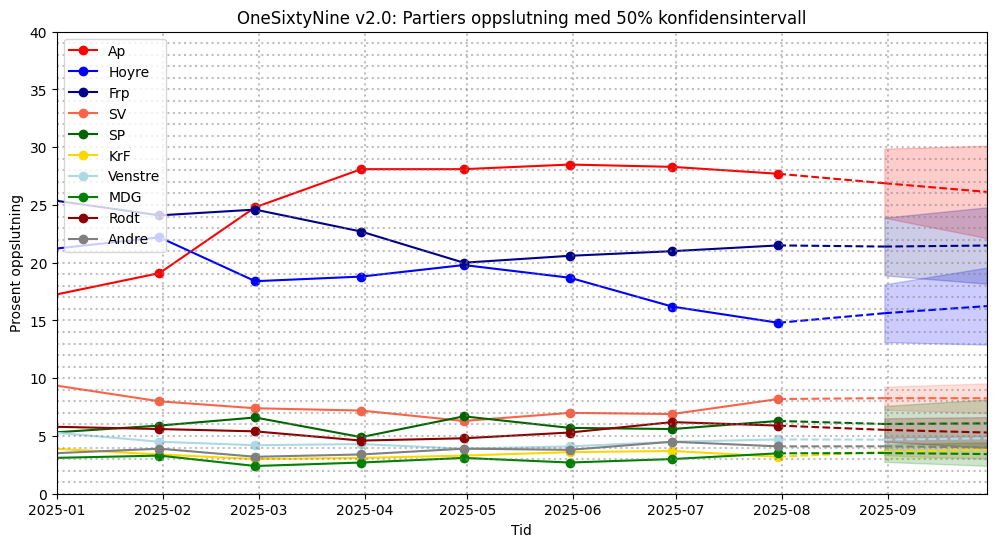

In [27]:
# Define a color map for consistency
colors = {
    'Ap': '#FF0000',        # Red
    'Hoyre': '#0000FF',     # Blue
    'Frp': '#00008B',       # Dark Blue
    'SV': '#FF6347',        # Light Red (Tomato)
    'SP': '#006400',        # Dark Green
    'KrF': '#FFD700',       # Yellow (Gold)
    'Venstre': '#ADD8E6',   # Light Blue
    'MDG': '#008000',       # Green
    'Rodt': '#8B0000',      # Dark Red
    'Andre': '#808080'      # Gray
}

plt.figure(figsize=(12, 6))

for party in colors.keys():  # Iterate over defined parties
    color = colors[party]  

    # Plot actual data
    plt.plot(df_en.index, df_en[party], marker="o", color=color, label=f"{party}")

    # Plot forecast 
    plt.plot(forecast_df.index, forecast_df[party], linestyle="dashed", color=color)

    last_actual_date = df_en.index[-1]
    first_forecast_date = forecast_df.index[0]
    last_actual_value = df_en[party].iloc[-1]
    first_forecast_value = forecast_df[party].iloc[0]

    plt.plot([last_actual_date, first_forecast_date], [last_actual_value, first_forecast_value], color=color, linestyle="dashed")
    
    # Plot confidence interval (original scale)
    plt.fill_between(forecast_df.index, 
                     forecast_lower_df[party], 
                     forecast_upper_df[party], 
                     color=color, alpha=0.2)


dates = pd.date_range(start="2023-01-01", end="2025-09-30", freq="MS") 
for date in dates:
    plt.axvline(date, color="gray", linestyle="dotted", alpha=0.5)

# Add horizontal grid lines every 5%
for percent in range(0, 45, 1):
    plt.axhline(percent, color="gray", linestyle="dotted", alpha=0.5)

plt.xlim(np.datetime64("2025-01-01"), np.datetime64("2025-09-30"))  # Manually set max date to Sept 2025
plt.ylim(0,40)  # Manually set max date to Sept 2025
plt.xlabel("Tid")
plt.ylabel("Prosent oppslutning")
plt.title("OneSixtyNine v2.0: Partiers oppslutning med 50% konfidensintervall")
plt.legend(loc="upper left")
plt.show()

In [28]:
forecast_df=forecast_df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]
forecast_lower_df=forecast_lower_df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]
forecast_upper_df=forecast_upper_df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]

In [29]:
###finn estimat for september
date_to_extract = "2025-09-30"

# Extract the row for the given date from each dataframe
estimate_row = forecast_df.loc[date_to_extract]
lower_row = forecast_lower_df.loc[date_to_extract]
upper_row = forecast_upper_df.loc[date_to_extract]

# Combine into a new DataFrame
result_df = pd.DataFrame({
    "Party": estimate_row.index,
    "Estimate": estimate_row.values,
    "Lower": lower_row.values,
    "Upper": upper_row.values
})

# Display the final structured DataFrame
print(result_df)

     Party   Estimate      Lower      Upper
0       Ap  26.129611  22.125646  30.133576
1    Hoyre  16.244929  12.908338  19.581520
2      Frp  21.488201  18.182966  24.793435
3       SV   8.265005   6.981330   9.548679
4       SP   6.088539   4.013333   8.163744
5      KrF   3.804030   3.126687   4.481373
6  Venstre   4.798675   4.119858   5.477493
7      MDG   3.431751   2.418695   4.444807
8     Rodt   5.297112   3.960869   6.633356
9    Andre   4.019511   3.015628   5.023393


In [30]:
# Multivariate MC!
n_sim = 1000000
# Extract mean estimates (yhat) and covariance matrix
yhat_vector = result_df["Estimate"].values  # Mean estimates for all parties
#yhat_vector = forecast_original_scale["Estimate"].values  # Mean estimates for all parties
#cov_matrix = forecast_cov[-1]  # Covariance matrix at final step (latest forecast)
cov_matrix = forecast_cov

# Generate correlated samples
samples = np.random.multivariate_normal(yhat_vector, cov_matrix, size=n_sim)
samples = np.maximum(samples, 1e-6) ##must be above 0
samples = (samples.T / samples.sum(axis=1)).T

# Create a DataFrame with sampled values
sampled_df = pd.DataFrame(samples, columns=result_df["Party"])

# Compute vote totals for each simulation
red_green_votes = sampled_df[["Ap", "SV", "SP", "Rodt", "MDG"]].sum(axis=1)/sampled_df.sum(axis=1)
blue_votes = sampled_df[["Hoyre", "Frp", "KrF", "Venstre"]].sum(axis=1)/sampled_df.sum(axis=1)

# Probability that red-green block wins
prob_red_green_wins = np.mean(red_green_votes > blue_votes)

print(f"Sannsyn for at Ap+SV+Sp+R+MDG > H+FrP+KrF+V: {prob_red_green_wins:.4f}")


Sannsyn for at Ap+SV+Sp+R+MDG > H+FrP+KrF+V: 0.7545


In [34]:
sampled_df.drop(columns=["Andre"], inplace=True)

In [35]:
sample_mandate=pd.DataFrame(columns=sampled_df.columns)

In [32]:
def calc_mandat(oppslutt):
    if oppslutt <4.0:
        mandat=np.round(1/4*oppslutt**2,0)
    else: 
        oppslutt=round(1.8119*oppslutt,0)
    return int(oppslutt)

In [33]:
for party in sampled_df.columns:
    sample_mandate[party]=sampled_df[party].apply(calc_mandat)

In [ ]:
sample_mandate

In [ ]:
sample_mandate['Sum']=sample_mandate.sum(axis=1)

In [ ]:
sample_mandate

In [ ]:
sample_169=sample_mandate[sample_mandate["Sum"]==169].copy()

In [ ]:
sample_169

In [ ]:
sample_169['red_green'] = sample_169[["Ap", "SV", "SP", "Rodt", "MDG"]].sum(axis=1)
sample_169['ap_sp'] = sample_169[["Ap", "SP"]].sum(axis=1)
sample_169['ap_sp_sv'] = sample_169[["Ap", "SP", "SV"]].sum(axis=1)
sample_169['ap_sp_sv_r'] = sample_169[["Ap", "SP", "SV", "Rodt"]].sum(axis=1)
sample_169['ap_sp_sv_r_mdg'] = sample_169[["Ap", "SP", "SV", "Rodt", "MDG"]].sum(axis=1)
sample_169['h_frp'] = sample_169[["Hoyre", "Frp"]].sum(axis=1)
sample_169['h_frp_v_krf'] = sample_169[["Hoyre", "Frp", "Venstre", "KrF"]].sum(axis=1)
sample_169['h_frp_v_krf_mdg'] = sample_169[["Hoyre", "Frp", "Venstre", "KrF", "MDG"]].sum(axis=1)

In [ ]:
sample_169['red_green_victory'] = sample_169['red_green'] >= 85
sample_169['ap_sp_victory'] = sample_169['ap_sp'] >= 85
sample_169['ap_sp_sv_victory'] = sample_169['ap_sp_sv'] >= 85
sample_169['ap_sp_sv_r'] = sample_169['ap_sp_sv_r'] >= 85
sample_169['ap_sp_sv_r_mdg'] = sample_169['ap_sp_sv_r_mdg'] >= 85
sample_169['h_frp'] = sample_169['h_frp'] >= 85
sample_169['h_frp_v_krf'] = sample_169['h_frp_v_krf'] >= 85
sample_169['h_frp_v_krf_mdg'] = sample_169['h_frp_v_krf_mdg'] >= 85

In [ ]:
sample_169['r_avh'] = (sample_169['ap_sp_sv'] < 85) & (sample_169['ap_sp_sv_r']) >= 85

In [ ]:
print(sample_169['red_green_victory'].mean())
print(sample_169['ap_sp_victory'].mean())
print(sample_169['ap_sp_sv_victory'].mean())
print(sample_169['ap_sp_sv_r'].mean())
print(sample_169['ap_sp_sv_r_mdg'].mean())
print(sample_169['h_frp'].mean())
print(sample_169['h_frp_v_krf'].mean())
print(sample_169['h_frp_v_krf_mdg'].mean())
print(sample_169['r_avh'].mean())

In [ ]:
sample_169.to_csv('sample.csv')

In [ ]:
import matplotlib.pyplot as plt

plt.hist(sample_169['ap_sp_sv'], bins=range(0, sample_169['ap_sp_sv'].max() + 2), edgecolor='black')
plt.title('Distribution of Mandates')
plt.xlabel('Mandates')
plt.ylabel('Number of Simulations')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()